In [102]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
import torchvision.models as models

import os

from sklearn.model_selection import train_test_split

In [103]:
import sys
import logging

logger = logging.getLogger("VGG16-training")

if logger.hasHandlers():
    logger.handlers.clear()
    
logger.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter(
    '%(asctime)s %(levelname)-5s %(name)s - %(message)s',
)
handler.setFormatter(formatter)

logger.addHandler(handler)

In [104]:
ANNOTATIONS_FOLDER = os.path.join('.', 'dataset', 'annotations')
IMAGES_FOLDER = os.path.join('.', 'dataset', 'images')

In [105]:
import re

annotations_paths = sorted(
    [os.path.join(ANNOTATIONS_FOLDER, xml_name) for xml_name in os.listdir(ANNOTATIONS_FOLDER)], 
    key=lambda x: int(re.search(r'\d+', x).group())
)

In [106]:
import xml.etree.ElementTree as ET

parsed_annotations = []

for xml_path in annotations_paths:
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    filename = root.find('filename').text
    
    size_node = root.find('size')
    width = int(size_node.find('width').text)
    height = int(size_node.find('height').text)
    
    object_node = root.find('object')
    bnd_node = object_node.find('bndbox')
    
    ymin = int(bnd_node.find('ymin').text)
    xmin = int(bnd_node.find('xmin').text)
    ymax = int(bnd_node.find('ymax').text)
    xmax = int(bnd_node.find('xmax').text)
    
    annotation_data = {
        'image_name': filename,
        'width': width,
        'height': height,
        'ymin': ymin,
        'xmin': xmin,
        'ymax': ymax,
        'xmax': xmax
    }
    
    parsed_annotations.append(annotation_data)
    
df = pd.DataFrame(parsed_annotations)

In [107]:
df.head(10)

,image_name,width,height,ymin,xmin,ymax,xmax
0,Cars0.png,500,268,125,226,173,419
1,Cars1.png,400,248,128,134,160,262
2,Cars2.png,400,400,176,229,193,270
3,Cars3.png,400,225,128,142,157,261
4,Cars4.png,590,350,82,156,253,503
5,Cars5.png,400,295,218,226,240,242
6,Cars6.png,500,375,114,112,239,373
7,Cars7.png,400,279,141,166,154,206
8,Cars8.png,500,232,104,204,134,304
9,Cars9.png,442,333,224,164,247,272


(-0.5, 441.5, 332.5, -0.5)

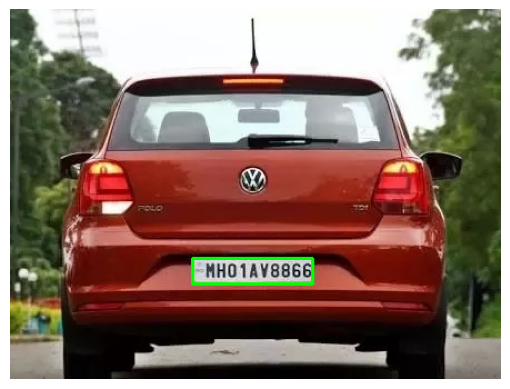

In [108]:
sample_image_row = df.iloc[9]

sample_image = cv2.imread(os.path.join(IMAGES_FOLDER, sample_image_row['image_name']))
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

ymin = sample_image_row['ymin']
xmin = sample_image_row['xmin']
ymax = sample_image_row['ymax']
xmax = sample_image_row['xmax']

cv2.rectangle(sample_image_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(sample_image_rgb)
plt.axis('off')

In [109]:
IMAGE_SIZE = 224

In [110]:
def resize_annotations(df, new_img_size=IMAGE_SIZE):
    df_res = df.copy()
    
    df_res['xmin'] = (df_res['xmin'] * (new_img_size / df_res['width'])).astype(int)
    df_res['ymin'] = (df_res['ymin'] * (new_img_size / df_res['height'])).astype(int)
    
    df_res['xmax'] = (df_res['xmax'] * (new_img_size / df_res['width'])).astype(int)
    df_res['ymax'] = (df_res['ymax'] * (new_img_size / df_res['height'])).astype(int)
    
    df_res['width'] = new_img_size
    df_res['height'] = new_img_size

    return df_res

In [111]:
df = resize_annotations(df)

df.head(10)

,image_name,width,height,ymin,xmin,ymax,xmax
0,Cars0.png,224,224,104,101,144,187
1,Cars1.png,224,224,115,75,144,146
2,Cars2.png,224,224,98,128,108,151
3,Cars3.png,224,224,127,79,156,146
4,Cars4.png,224,224,52,59,161,190
5,Cars5.png,224,224,165,126,182,135
6,Cars6.png,224,224,68,50,142,167
7,Cars7.png,224,224,113,92,123,115
8,Cars8.png,224,224,100,91,129,136
9,Cars9.png,224,224,150,83,166,137


(-0.5, 223.5, 223.5, -0.5)

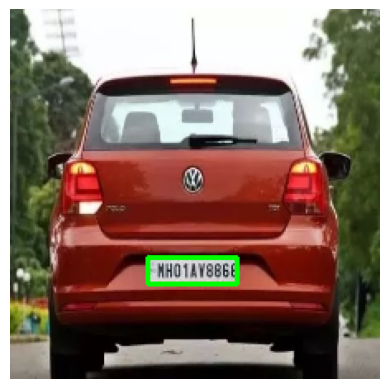

In [112]:
sample_image_row = df.iloc[9]

sample_image = cv2.imread(os.path.join(IMAGES_FOLDER, sample_image_row['image_name']))
sample_image = cv2.resize(sample_image, (IMAGE_SIZE, IMAGE_SIZE))
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

ymin = sample_image_row['ymin']
xmin = sample_image_row['xmin']
ymax = sample_image_row['ymax']
xmax = sample_image_row['xmax']

cv2.rectangle(sample_image_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(sample_image_rgb)
plt.axis('off')

In [113]:
def load_dataset(df_annotations):
    X = []
    y = []
    
    for _, row in df_annotations.iterrows():
        src_image = cv2.imread(os.path.join(IMAGES_FOLDER, row['image_name']))
        resized_image = cv2.resize(src_image, (IMAGE_SIZE, IMAGE_SIZE))
    
        ymin = row['ymin']
        xmin = row['xmin']
        ymax = row['ymax']
        xmax = row['xmax']
        
        X.append(np.array(resized_image))
        y.append(np.array([xmax, ymax, xmin, ymin]))
        
    return np.array(X), np.array(y)
    

In [114]:
X, y = load_dataset(df)

print(f'Images array shape: {X.shape}')
print(f'Feature vector shape: {y.shape}')

Images array shape: (433, 224, 224, 3)
Feature vector shape: (433, 4)


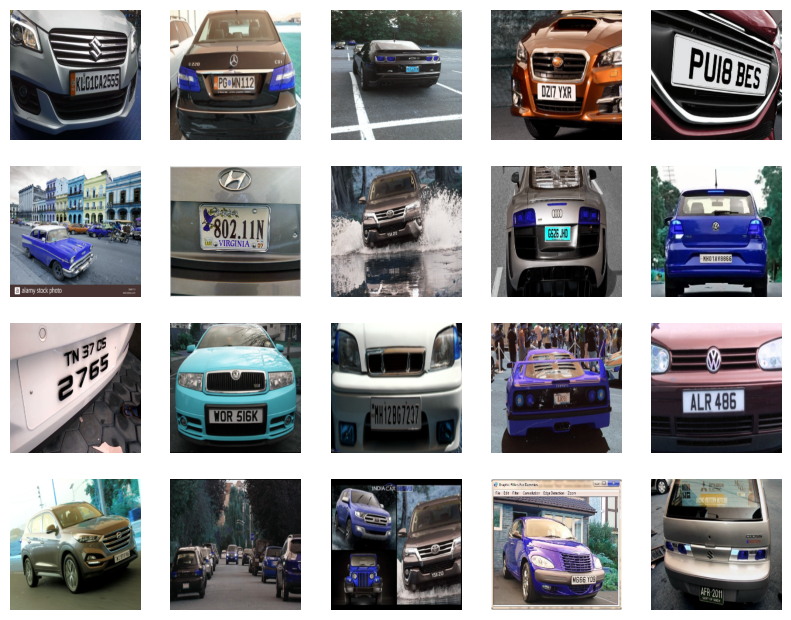

In [115]:
plt.figure(figsize=(10, 20))

for i in range(0, 20):
    plt.subplot(10, 5, i + 1)
    plt.axis('off')
    plt.imshow(X[i])

In [116]:
X = X / 255
y = y / 255

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=24)

In [118]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')

print(f'X val shape: {X_val.shape}')
print(f'y val shape: {y_val.shape}')

print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (311, 224, 224, 3)
y train shape: (311, 4)
X val shape: (35, 224, 224, 3)
y val shape: (35, 4)
X test shape: (87, 224, 224, 3)
y test shape: (87, 4)


In [119]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f'Device: {DEVICE}')

2025-05-04 18:51:01,481 INFO  VGG16-training - Device: cuda


In [120]:
class VGG16Custom(nn.Module):
    def __init__(self):
        super(VGG16Custom, self).__init__()
        vgg16 = models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES)
        
        for param in vgg16.features.parameters():
            param.requires_grad = False
        
        self.features = vgg16.features
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        
        return x
    
    def predict(self, image):
        self.eval()
        input_tensor = torch.from_numpy(np.transpose(image, (2, 0, 1))).float().unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            output = self.forward(input_tensor).squeeze()
            
        return output.cpu().numpy()
        

In [138]:
n_epochs = 15
batch_size = 32
n_samples = X_train.shape[0]

In [139]:
import time

model = VGG16Custom().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

logger.info(f'Start training model')

training_start_time = time.time()

for epoch in range(n_epochs):
    logger.info(f'Start training epoch {epoch}/{n_epochs}')
    
    epoch_start_time = time.time()
    
    model.train()
    epoch_loss = 0.0
    
    indices = torch.randperm(n_samples)
    
    for batch_idx in range(0, n_samples, batch_size):
        items_idx = indices[batch_idx:batch_idx + batch_size]
        X_train_batch = torch.tensor(X_train[items_idx], dtype=torch.float32).permute(0, 3, 1, 2).to(DEVICE)
        y_train_batch = torch.tensor(y_train[items_idx], dtype=torch.float32).to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(X_train_batch)
        loss = criterion(outputs, y_train_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    logger.info(f'Finish training epoch {epoch}/{n_epochs}. Loss: {epoch_loss:.4f}. Time elapsed: {time.time() - epoch_start_time:.2f} seconds')
    
logger.info(f'Finish training model. Time elapsed: {time.time() - training_start_time:.2f} seconds')

2025-05-04 18:55:23,855 INFO  VGG16-training - Start training model
2025-05-04 18:55:23,857 INFO  VGG16-training - Start training epoch 0/15
2025-05-04 18:55:26,395 INFO  VGG16-training - Finish training epoch 0/15. Loss: 0.2211. Time elapsed: 2.54 seconds
2025-05-04 18:55:26,396 INFO  VGG16-training - Start training epoch 1/15
2025-05-04 18:55:28,564 INFO  VGG16-training - Finish training epoch 1/15. Loss: 0.1375. Time elapsed: 2.17 seconds
2025-05-04 18:55:28,565 INFO  VGG16-training - Start training epoch 2/15
2025-05-04 18:55:30,744 INFO  VGG16-training - Finish training epoch 2/15. Loss: 0.0751. Time elapsed: 2.18 seconds
2025-05-04 18:55:30,745 INFO  VGG16-training - Start training epoch 3/15
2025-05-04 18:55:32,940 INFO  VGG16-training - Finish training epoch 3/15. Loss: 0.0455. Time elapsed: 2.19 seconds
2025-05-04 18:55:32,941 INFO  VGG16-training - Start training epoch 4/15
2025-05-04 18:55:35,116 INFO  VGG16-training - Finish training epoch 4/15. Loss: 0.0309. Time elapsed: 

In [140]:
OUTPUT_FOLDER = os.path.join('.', 'output')

In [141]:
torch.save(model.state_dict(), os.path.join(OUTPUT_FOLDER, 'model.pt'))

In [142]:
def predict(model, normalized_input_image):
    prediction = model.predict(normalized_input_image)
    
    return (prediction * 255).astype(np.uint8)

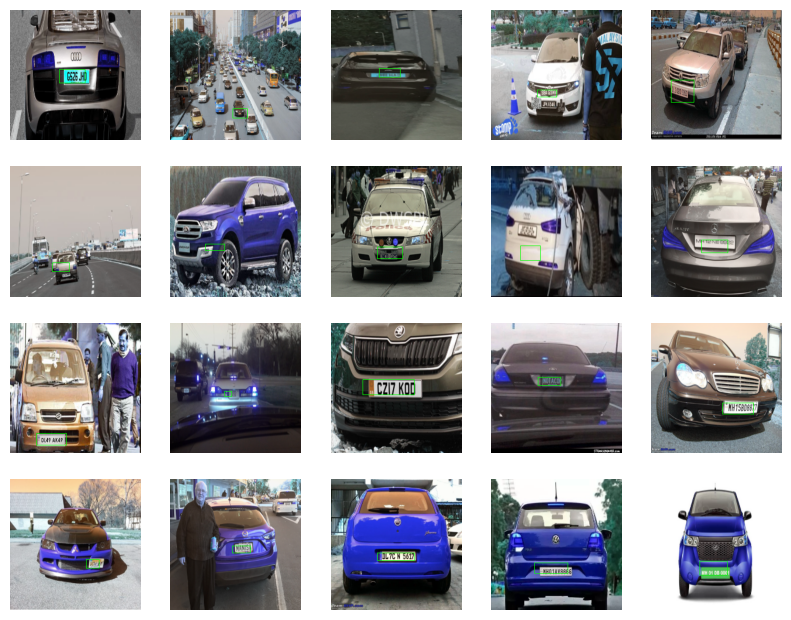

In [143]:
plt.figure(figsize=(10, 20))

for i in range(0, 20):
    cur_image = X_test[i]
    box = predict(model, cur_image)
    cur_image = (cur_image * 255).astype(int)
    cur_image = cv2.rectangle(
        cur_image,
        (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
        (0, 255, 0)
    )
    
    plt.subplot(10, 5, i + 1)
    plt.axis('off')
    plt.imshow(cur_image)